In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss

In [15]:
final_train = pd.read_excel('../data/final_train.xlsx' ,usecols=lambda x: x not in ['Unnamed: 0', 'Unnamed: 0.1'])
final_test = pd.read_excel('../data/final_test.xlsx', usecols=lambda x: x not in ['Unnamed: 0', 'Unnamed: 0.1'])
final_oot = pd.read_excel('../data/final_oot.xlsx' ,usecols=lambda x: x not in ['Unnamed: 0', 'Unnamed: 0.1'])

In [21]:
for x in final_train.columns.tolist():
  taux_defaut = final_train.groupby(x)['DDefaut_NDB'].mean()
  print(taux_defaut)

DDefaut_NDB
0    0.0
1    1.0
Name: DDefaut_NDB, dtype: float64
CODNAF2
0    0.024540
1    0.065481
Name: DDefaut_NDB, dtype: float64
CODETAJUR
0    0.049131
1    0.062654
Name: DDefaut_NDB, dtype: float64
CRTOC_AG_MVTAFF_2T_IND_0010
0    0.021304
1    0.055508
2    0.201160
Name: DDefaut_NDB, dtype: float64
CRTOC_AG_NBJCRE_2T_IND_0009
0    0.018286
1    0.061114
2    0.141677
3    0.350485
Name: DDefaut_NDB, dtype: float64
CRTOC_IND_0164
0    0.027149
1    0.425000
Name: DDefaut_NDB, dtype: float64
CRTOC_AG_LIGDEB_2T_IND_0015
0    0.022641
1    0.227068
Name: DDefaut_NDB, dtype: float64
CRTOC_IND_0015
0    0.022745
1    0.097493
2    0.494382
Name: DDefaut_NDB, dtype: float64


In [16]:
CODNAF2 = {0: 1, 1: 0} 
final_train['CODNAF2'] = final_train['CODNAF2'].map(CODNAF2)
CRTOC_AG_MVTAFF_2T_IND_0010= {0: 2, 1: 1, 2:0} 
final_train['CRTOC_AG_MVTAFF_2T_IND_0010'] = final_train['CRTOC_AG_MVTAFF_2T_IND_0010'].map(CRTOC_AG_MVTAFF_2T_IND_0010)
CRTOC_AG_NBJCRE_2T_IND_0009={0: 3, 1: 2, 2:1,3:0} 
final_train['CRTOC_AG_NBJCRE_2T_IND_0009'] = final_train['CRTOC_AG_NBJCRE_2T_IND_0009'].map(CRTOC_AG_NBJCRE_2T_IND_0009)
CRTOC_IND_0164 = {0: 1, 1: 0} 
final_train['CRTOC_IND_0164'] = final_train['CRTOC_IND_0164'].map(CRTOC_IND_0164)
CRTOC_AG_LIGDEB_2T_IND_0015 = {0: 1, 1: 0} 
final_train['CRTOC_AG_LIGDEB_2T_IND_0015'] = final_train['CRTOC_AG_LIGDEB_2T_IND_0015'].map(CRTOC_AG_LIGDEB_2T_IND_0015)

In [17]:
variables=final_train.columns.tolist()
variables.remove('DDefaut_NDB')

X_train = final_train[variables]
X_test = final_test[variables]
X_oot = final_oot[variables]

y_train = final_train['DDefaut_NDB']
y_test = final_test['DDefaut_NDB']
y_oot = final_oot['DDefaut_NDB']

# X_train = sm.add_constant(X_train)

In [ ]:
import statsmodels.api as sm
# Initialisation
best_model = None
best_aic = float('inf')
selected_vars = []
all_vars = variables[:]  # Copie de la liste complète des variables

while True:
    # Trouver les variables restantes
    remaining_vars = list(set(all_vars) - set(selected_vars))
    candidate_models = []

    # Construire des modèles candidats en ajoutant une variable restante
    for var in remaining_vars:
        temp_vars = selected_vars + [var]

        try:
            # Construction du modèle
            X_train_sm = sm.add_constant(pd.DataFrame(X_train, columns=all_vars)[temp_vars])
            model = sm.Logit(y_train, X_train_sm).fit(disp=0)  # Ajuster un modèle Logit

            # Stocker le modèle et ses métriques
            candidate_models.append((var, model, model.aic))
        except Exception as e:
            print(f"Erreur avec la variable {var} : {e}")
            continue

    # Si aucun modèle candidat, sortir de la boucle
    if not candidate_models:
        break

    # Sélectionner le modèle avec le plus petit AIC
    best_candidate = min(candidate_models, key=lambda x: x[2])

    # Mettre à jour si le nouveau modèle est meilleur
    if best_candidate[2] < best_aic:
        best_model = best_candidate[1]
        best_aic = best_candidate[2]
        selected_vars.append(best_candidate[0])
    else:
        # Si aucun amélioration n'est trouvée, arrêter la sélection
        break

# Affichage des résultats
if best_model:
    print("Variables sélectionnées :", selected_vars)
    print(best_model.summary())
else:
    print("Aucun modèle valide trouvé.")


Variables sélectionnées : ['CRTOC_IND_0015', 'CRTOC_AG_MVTAFF_2T_IND_0010', 'CRTOC_AG_LIGDEB_2T_IND_0015', 'CRTOC_IND_0164', 'CODNAF2', 'CODETAJUR', 'CRTOC_AG_NBJCRE_2T_IND_0009']
                           Logit Regression Results                           
Dep. Variable:            DDefaut_NDB   No. Observations:                14718
Model:                          Logit   Df Residuals:                    14710
Method:                           MLE   Df Model:                            7
Date:                Tue, 07 Jan 2025   Pseudo R-squ.:                  0.3904
Time:                        11:41:08   Log-Likelihood:                -2026.1
converged:                       True   LL-Null:                       -3323.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

## encodage

In [18]:
variables=final_train.columns.tolist()
variables.remove('DDefaut_NDB')

def encoder_one_hot(df, variables):
    df_encoded = pd.get_dummies(df, columns=variables,drop_first=True) #drop_first=True
    df_encoded = df_encoded.astype(int)
    return df_encoded

# final_train_e = encoder_one_hot(final_train, variables_a_encoder)
# final_test_e = encoder_one_hot(final_test, variables_a_encoder)
# final_oot_e = encoder_one_hot(final_oot, variables_a_encoder)

final_train_e = encoder_one_hot(final_train, variables)
final_test_e = encoder_one_hot(final_test, variables)
final_oot_e = encoder_one_hot(final_oot, variables)

final_train_e.head()
# print(final_test.head())
# print(final_oot.head())

,DDefaut_NDB,CODNAF2_1,CODETAJUR_1,CRTOC_AG_MVTAFF_2T_IND_0010_1,CRTOC_AG_MVTAFF_2T_IND_0010_2,CRTOC_AG_NBJCRE_2T_IND_0009_1,CRTOC_AG_NBJCRE_2T_IND_0009_2,CRTOC_AG_NBJCRE_2T_IND_0009_3,CRTOC_IND_0164_1,CRTOC_AG_LIGDEB_2T_IND_0015_1,CRTOC_IND_0015_1,CRTOC_IND_0015_2
0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,0,0


In [22]:
variables=final_train_e.columns.tolist()
variables.remove('DDefaut_NDB')

X_train_e = final_train_e[variables]
X_test_e = final_test_e[variables]
X_oot_e = final_oot_e[variables]

y_train_e = final_train_e['DDefaut_NDB']
y_test_e = final_test_e['DDefaut_NDB']
y_oot_e = final_oot_e['DDefaut_NDB']

# X_train = sm.add_constant(X_train)

In [23]:
# Sélection des variables à utiliser pour le modèle
selected_vars = variables[:]  # Liste des variables que vous voulez inclure dans le modèle

# Préparation des données
X_train_sm = sm.add_constant(pd.DataFrame(X_train_e, columns=selected_vars))  # Ajouter une constante
y_train_sm = y_train_e  # Variable cible

# Construction du modèle de régression logistique
model = sm.Logit(y_train_sm, X_train_sm).fit()

# Affichage des résultats
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.137378
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            DDefaut_NDB   No. Observations:                14718
Model:                          Logit   Df Residuals:                    14706
Method:                           MLE   Df Model:                           11
Date:                Tue, 07 Jan 2025   Pseudo R-squ.:                  0.3917
Time:                        11:51:44   Log-Likelihood:                -2021.9
converged:                       True   LL-Null:                       -3323.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -6.1727      0.213    -28.951      0.


=== Performance sur Train ===
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     13841
           1       0.82      0.45      0.58       877

    accuracy                           0.96     14718
   macro avg       0.89      0.72      0.78     14718
weighted avg       0.96      0.96      0.96     14718

Confusion Matrix:
 [[13755    86]
 [  482   395]]
AUC-ROC: 0.88 | Gini: 0.76
AUC-PR: 0.60 | AUC-PR aléatoire: 0.06 | RP: 10.07


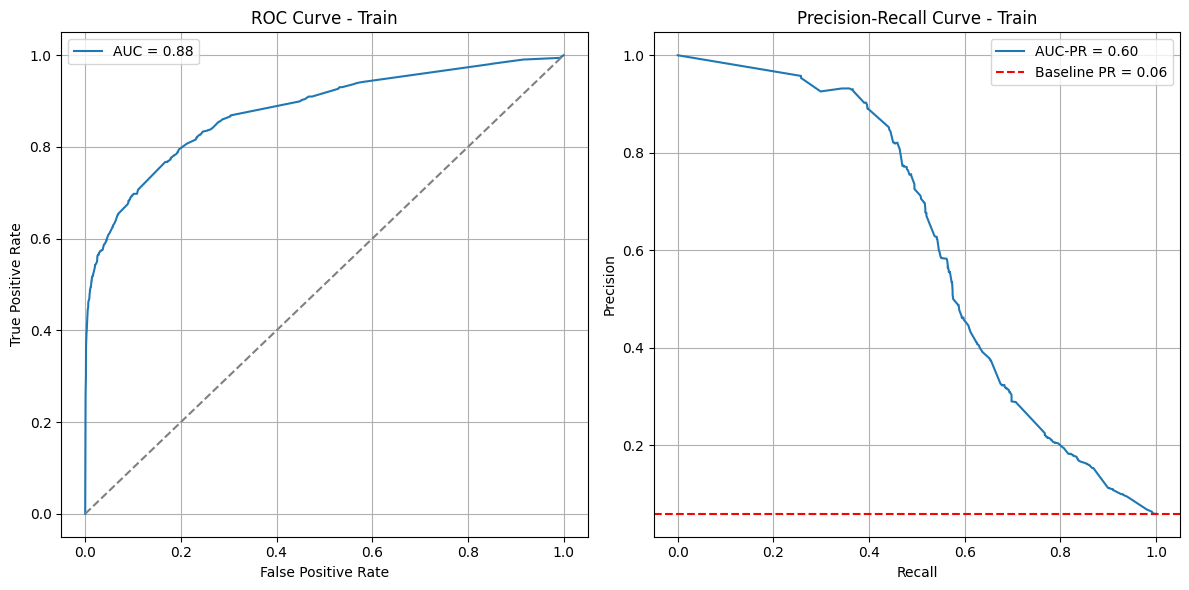


=== Performance sur Test ===
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84      4615
           1       0.01      0.03      0.01       291

    accuracy                           0.72      4906
   macro avg       0.47      0.40      0.42      4906
weighted avg       0.87      0.72      0.79      4906

Confusion Matrix:
 [[3519 1096]
 [ 283    8]]
AUC-ROC: 0.17 | Gini: -0.66
AUC-PR: 0.04 | AUC-PR aléatoire: 0.06 | RP: 0.60


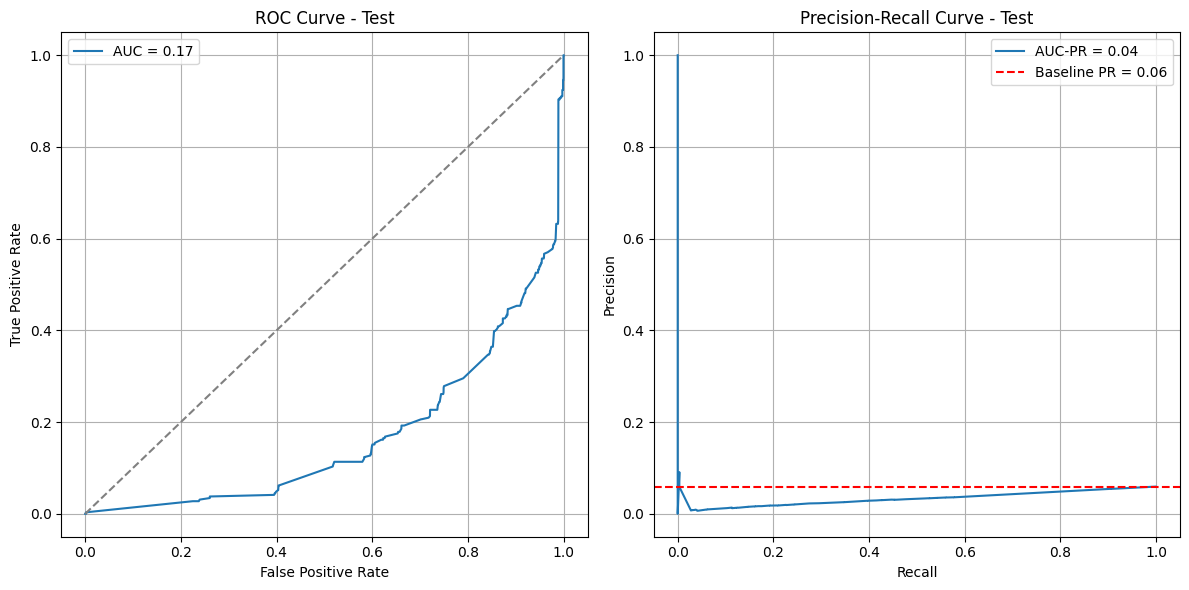


=== Performance sur OOT ===
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.75      0.83      6203
           1       0.01      0.05      0.02       406

    accuracy                           0.71      6609
   macro avg       0.47      0.40      0.42      6609
weighted avg       0.87      0.71      0.78      6609

Confusion Matrix:
 [[4663 1540]
 [ 387   19]]
AUC-ROC: 0.18 | Gini: -0.64
AUC-PR: 0.04 | AUC-PR aléatoire: 0.06 | RP: 0.65


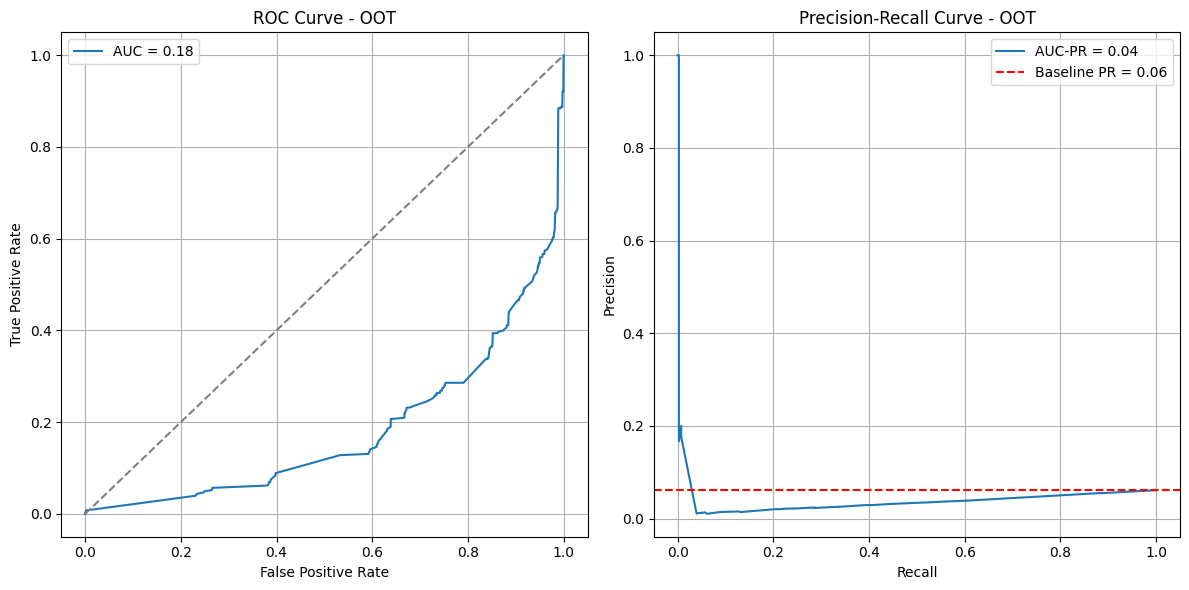


Résumé des performances :
  Dataset      Gini   AUC-ROC    AUC-PR  Ratio de Performance (RP)
0   Train  0.755864  0.877932  0.600120                  10.071348
1    Test -0.664437  0.167782  0.035664                   0.601256
2     OOT -0.638866  0.180567  0.039676                   0.645857


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import statsmodels.api as sm
import pandas as pd

def evaluate_model_with_gini(model, X, y, dataset_name="Dataset", selected_vars=None):
    """
    Fonction pour évaluer un modèle avec Gini, AUC-ROC, AUC-PR, PR et Ratio de Performance
    """
    if selected_vars is None:
        selected_vars = X.columns.tolist()  # Si aucune variable n'est donnée, utiliser toutes les colonnes
    
    # Ajouter une constante pour l'intercept
    X_sm = sm.add_constant(X[selected_vars])  
    y_pred_prob = model.predict(X_sm)  # Probabilités prédites
    y_pred_class = (y_pred_prob >= 0.5).astype(int)  # Classification binaire à 0.5

    # Métriques ROC
    auc_roc = roc_auc_score(y, y_pred_prob)
    gini = 2 * auc_roc - 1  # Calcul du Gini

    # Métriques PR
    precision, recall, thresholds_pr = precision_recall_curve(y, y_pred_prob)
    auc_pr = average_precision_score(y, y_pred_prob)

    # AUC-PR du modèle aléatoire
    prevalence = sum(y) / len(y)
    auc_pr_random = prevalence
    rp = auc_pr / auc_pr_random  # Ratio de performance

    # Afficher les métriques
    print(f"\n=== Performance sur {dataset_name} ===")
    print("Classification Report:\n", classification_report(y, y_pred_class))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred_class))
    print(f"AUC-ROC: {auc_roc:.2f} | Gini: {gini:.2f}")
    print(f"AUC-PR: {auc_pr:.2f} | AUC-PR aléatoire: {auc_pr_random:.2f} | RP: {rp:.2f}")

    # Courbe ROC
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve - {dataset_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()

    # Courbe PR
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.2f}")
    plt.axhline(y=auc_pr_random, color='red', linestyle='--', label=f"Baseline PR = {auc_pr_random:.2f}")
    plt.title(f"Precision-Recall Curve - {dataset_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    return gini, auc_roc, auc_pr, rp

# ======================================================
# Évaluation sur les trois échantillons
# ======================================================
X_train_eval = pd.DataFrame(X_train_e, columns=variables)
X_test_eval = pd.DataFrame(X_test_e, columns=variables)
X_oot_eval = pd.DataFrame(X_oot_e, columns=variables)

gini_train, auc_roc_train, auc_pr_train, rp_train = evaluate_model_with_gini(model, X_train_eval, y_train, "Train", selected_vars)
gini_test, auc_roc_test, auc_pr_test, rp_test = evaluate_model_with_gini(model, X_test_eval, y_test, "Test", selected_vars)
gini_oot, auc_roc_oot, auc_pr_oot, rp_oot = evaluate_model_with_gini(model, X_oot_eval, y_oot, "OOT", selected_vars)

# ======================================================
# Résumé des performances
# ======================================================
performance_summary = pd.DataFrame({
    "Dataset": ["Train", "Test", "OOT"],
    "Gini": [gini_train, gini_test, gini_oot],
    "AUC-ROC": [auc_roc_train, auc_roc_test, auc_roc_oot],
    "AUC-PR": [auc_pr_train, auc_pr_test, auc_pr_oot],
    "Ratio de Performance (RP)": [rp_train, rp_test, rp_oot]
})
print("\nRésumé des performances :")
print(performance_summary)
